c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9328 - loss: 0.2399 - val_accuracy: 0.9872 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 2/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - accuracy: 0.9826 - loss: 0.0787 - val_accuracy: 0.9904 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 3/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 922us/step - accuracy: 0.9853 - loss: 0.0667 - val_accuracy: 0.9920 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 4/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - accuracy: 0.9877 - loss: 0.0607 - val_accuracy: 0.9932 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step - accuracy: 0.9887 - loss: 0.0566 - val_accuracy: 0.9925 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 6/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.9880 - loss: 0.0575 - val_accuracy: 0.9932 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 7/100
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - a

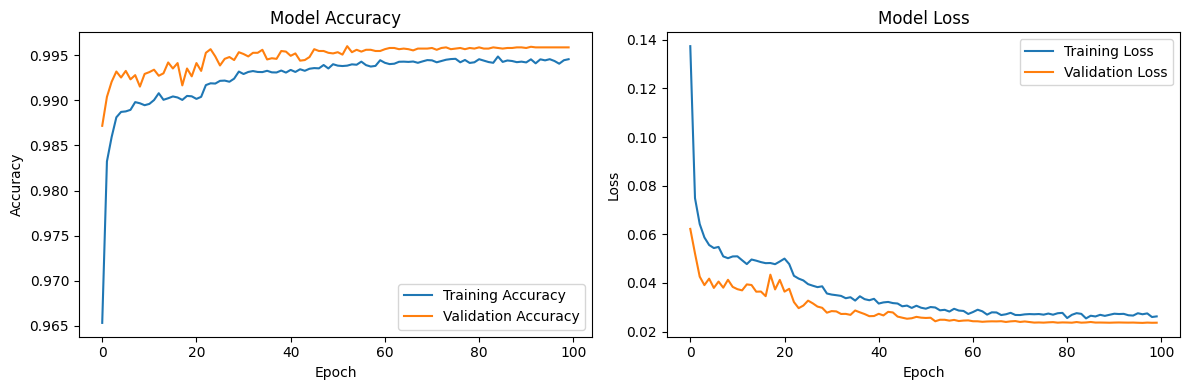

Model saved successfully!


In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers, callbacks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pretty_midi

# Load dataset
dataset_path = "output/v9/dataset_features.csv"
df = pd.read_csv(dataset_path)

# Preprocess data
feature_columns = [col for col in df.columns if col not in ['midi_file', 'error_type', 'has_error']]
X = df[feature_columns].values
y = df['error_type']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 of 85% ≈ 15% of total

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build TensorFlow model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        
        layers.Dense(128, 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l1(1e-5)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Build model
num_classes = len(label_encoder.classes_)
model = build_model((X_train.shape[1],), num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,  
    callbacks=[early_stopping, lr_reducer],
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save('midi_error_detection_model_v2.h5')
print("Model saved successfully!")


# Load model function
def load_model_from_file(model_path: str):
    """Load the pre-trained model from a file."""
    return tf.keras.models.load_model(model_path)


class FeatureExtractor:
    def __init__(self, original_midi_path: str):
        """Initialize with a reference to the original MIDI file."""
        self.original_midi = pretty_midi.PrettyMIDI(original_midi_path)
    
    def extract_features(self, midi: pretty_midi.PrettyMIDI):
        """Extract enhanced features for mistake detection."""
        features = {}
        notes = midi.instruments[0].notes
        
        # Basic temporal features
        note_timings = [note.start for note in notes]
        if len(note_timings) > 1:
            ioi_diffs = np.diff(note_timings)
            features['avg_ioi'] = np.mean(ioi_diffs)
            features['std_ioi'] = np.std(ioi_diffs)
            features['max_ioi'] = np.max(ioi_diffs)
            features['ioi_range'] = np.max(ioi_diffs) - np.min(ioi_diffs)
        else:
            features.update({'avg_ioi': 0, 'std_ioi': 0, 'max_ioi': 0, 'ioi_range': 0})
            
        # Enhanced timing features
        if len(notes) > 1:
            timing_diffs = np.diff([note.start for note in notes])
            features['timing_irregularity'] = np.std(timing_diffs) / np.mean(timing_diffs)
            features['max_timing_jump'] = np.max(timing_diffs)
            
            overlaps = []
            for i in range(len(notes)-1):
                if notes[i].end > notes[i+1].start:
                    overlaps.append(notes[i].end - notes[i+1].start)
            features['overlap_count'] = len(overlaps)
            features['max_overlap'] = max(overlaps) if overlaps else 0
            
        # Enhanced pitch features
        pitches = [note.pitch for note in notes]
        if len(pitches) > 1:
            pitch_diffs = np.abs(np.diff(pitches))
            features['pitch_irregularity'] = np.std(pitch_diffs)
            features['small_intervals'] = np.sum(pitch_diffs <= 2) / len(pitch_diffs)
            features['large_jumps'] = np.sum(pitch_diffs >= 12) / len(pitch_diffs)
            
            scale_degrees = [p % 12 for p in pitches]
            features['non_scale_notes'] = sum(1 for d in scale_degrees if d not in [0,2,4,5,7,9,11]) / len(pitches)
        
        original_notes = self.original_midi.instruments[0].notes
        features['note_count_diff'] = len(notes) - len(original_notes)
        
        total_duration = notes[-1].end - notes[0].start if notes else 0
        features['note_density'] = len(notes) / total_duration if total_duration > 0 else 0
        
        return features

# Prediction Function
def predict_from_midi(midi_path: str, feature_extractor: FeatureExtractor, scaler: StandardScaler, model: tf.keras.Model, label_encoder: LabelEncoder):
    """Predict the error type from a MIDI file."""
    # Load and extract features
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    features = feature_extractor.extract_features(midi_data)
    
    # Convert features to DataFrame for consistency
    feature_vector = pd.DataFrame([features])
    
    # Normalize features
    normalized_features = scaler.transform(feature_vector)
    
    # Predict probabilities
    predictions_probs = model.predict(normalized_features)
    
    # Get the class index with the highest probability
    predicted_class_index = np.argmax(predictions_probs, axis=1)
    
    # Decode the predicted class index into a human-readable label
    predicted_label = label_encoder.inverse_transform(predicted_class_index)
    
    return predicted_label[0]
  
if __name__ == "__main__":
    original_midi_path = 'input/twinkle-twinkle-little-star.mid'
    feature_extractor = FeatureExtractor(original_midi_path)

Training on Fold 1
Epoch 1/100


c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9336 - loss: 0.2418 - val_accuracy: 0.9884 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9836 - loss: 0.0737 - val_accuracy: 0.9866 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9861 - loss: 0.0663 - val_accuracy: 0.9908 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9879 - loss: 0.0575 - val_accuracy: 0.9891 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9887 - loss: 0.0549 - val_accuracy: 0.9908 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9884 - loss: 0.0558 - val_accuracy: 0.9941 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9893 - loss: 

Training on Fold 2
Epoch 1/100


c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9379 - loss: 0.2229 - val_accuracy: 0.9898 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9832 - loss: 0.0771 - val_accuracy: 0.9902 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9861 - loss: 0.0649 - val_accuracy: 0.9926 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9876 - loss: 0.0588 - val_accuracy: 0.9916 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9882 - loss: 0.0559 - val_accuracy: 0.9904 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9889 - loss: 0.0526 - val_accuracy: 0.9894 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9893 - loss: 

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9337 - loss: 0.2373 - val_accuracy: 0.9890 - val_loss: 0.0527 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9830 - loss: 0.0772 - val_accuracy: 0.9916 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9857 - loss: 0.0653 - val_accuracy: 0.9894 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9867 - loss: 0.0633 - val_accuracy: 0.9930 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9886 - loss: 0.0566 - val_accuracy: 0.9931 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9885 - loss: 0.0552 - val_accuracy: 0.9916 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9893 - loss: 

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9341 - loss: 0.2308 - val_accuracy: 0.9893 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9834 - loss: 0.0761 - val_accuracy: 0.9918 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9859 - loss: 0.0647 - val_accuracy: 0.9933 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9888 - loss: 0.0550 - val_accuracy: 0.9937 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9884 - loss: 0.0546 - val_accuracy: 0.9931 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9895 - loss: 0.0519 - val_accuracy: 0.9920 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9900 - loss: 

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9411 - loss: 0.2200 - val_accuracy: 0.9875 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9830 - loss: 0.0779 - val_accuracy: 0.9938 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9861 - loss: 0.0636 - val_accuracy: 0.9914 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9880 - loss: 0.0581 - val_accuracy: 0.9923 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9879 - loss: 0.0571 - val_accuracy: 0.9918 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9885 - loss: 0.0556 - val_accuracy: 0.9831 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9888 - loss: 

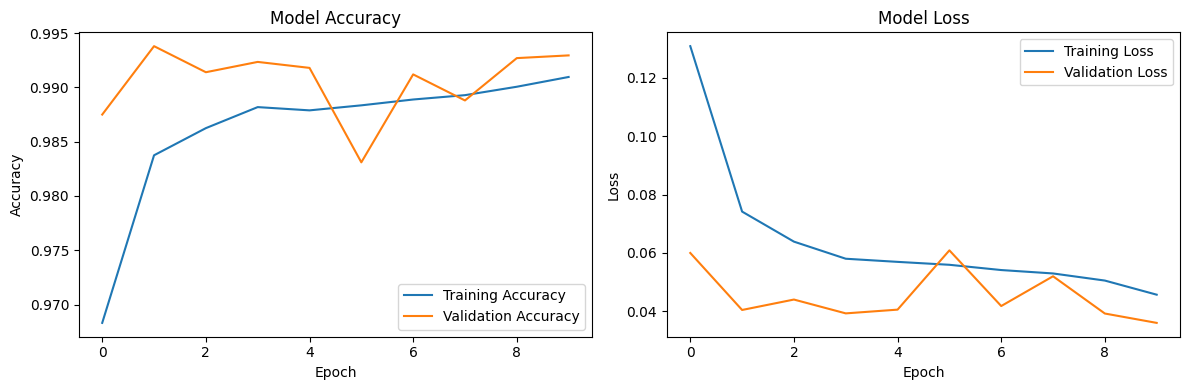

Model saved successfully!


In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers, callbacks
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pretty_midi

# Build TensorFlow model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        
        # First layer - reduced size
        layers.Dense(128, 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l1(1e-5)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Second layer
        layers.Dense(64,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Set up early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Load dataset
dataset_path = "output/v9/dataset_features.csv"
df = pd.read_csv(dataset_path)

# Preprocess data
feature_columns = [col for col in df.columns if col not in ['midi_file', 'error_type', 'has_error']]
X = df[feature_columns].values
y = df['error_type']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)


kf = KFold(n_splits=5, shuffle=True)

fold_accuracy = []
fold_loss = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training on Fold {fold + 1}")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    
    # Normalize features
    scaler = MinMaxScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Build and compile model
    model = build_model((X_train_fold.shape[1],), num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,
        batch_size=32,  # Adjust batch size if necessary
        callbacks=[early_stopping, lr_reducer],
        verbose=1
    )
    
    # Evaluate model
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    fold_accuracy.append(val_accuracy)
    fold_loss.append(val_loss)
    
    tf.keras.backend.clear_session()

# Compute average metrics
avg_accuracy = np.mean(fold_accuracy)
avg_loss = np.mean(fold_loss)

print(f"\nAverage Validation Accuracy: {avg_accuracy:.4f}")
print(f"Average Validation Loss: {avg_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save('midi_error_detection_model_v2.h5')
print("Model saved successfully!")


# Load model function
def load_model_from_file(model_path: str):
    """Load the pre-trained model from a file."""
    return tf.keras.models.load_model(model_path)



class FeatureExtractor:
    def __init__(self, original_midi_path: str):
        """Initialize with a reference to the original MIDI file."""
        self.original_midi = pretty_midi.PrettyMIDI(original_midi_path)
    
    def extract_features(self, midi: pretty_midi.PrettyMIDI):
        """Extract enhanced features for mistake detection."""
        features = {}
        notes = midi.instruments[0].notes
        
        # Basic temporal features
        note_timings = [note.start for note in notes]
        if len(note_timings) > 1:
            ioi_diffs = np.diff(note_timings)
            features['avg_ioi'] = np.mean(ioi_diffs)
            features['std_ioi'] = np.std(ioi_diffs)
            features['max_ioi'] = np.max(ioi_diffs)
            features['ioi_range'] = np.max(ioi_diffs) - np.min(ioi_diffs)
        else:
            features.update({'avg_ioi': 0, 'std_ioi': 0, 'max_ioi': 0, 'ioi_range': 0})
            
        # Enhanced timing features
        if len(notes) > 1:
            timing_diffs = np.diff([note.start for note in notes])
            features['timing_irregularity'] = np.std(timing_diffs) / np.mean(timing_diffs)
            features['max_timing_jump'] = np.max(timing_diffs)
            
            overlaps = []
            for i in range(len(notes)-1):
                if notes[i].end > notes[i+1].start:
                    overlaps.append(notes[i].end - notes[i+1].start)
            features['overlap_count'] = len(overlaps)
            features['max_overlap'] = max(overlaps) if overlaps else 0
            
        # Enhanced pitch features
        pitches = [note.pitch for note in notes]
        if len(pitches) > 1:
            pitch_diffs = np.abs(np.diff(pitches))
            features['pitch_irregularity'] = np.std(pitch_diffs)
            features['small_intervals'] = np.sum(pitch_diffs <= 2) / len(pitch_diffs)
            features['large_jumps'] = np.sum(pitch_diffs >= 12) / len(pitch_diffs)
            
            scale_degrees = [p % 12 for p in pitches]
            features['non_scale_notes'] = sum(1 for d in scale_degrees if d not in [0,2,4,5,7,9,11]) / len(pitches)
        
        original_notes = self.original_midi.instruments[0].notes
        features['note_count_diff'] = len(notes) - len(original_notes)
        
        total_duration = notes[-1].end - notes[0].start if notes else 0
        features['note_density'] = len(notes) / total_duration if total_duration > 0 else 0
        
        return features

# Prediction Function
def predict_from_midi(midi_path: str, feature_extractor: FeatureExtractor, scaler: StandardScaler, model: tf.keras.Model, label_encoder: LabelEncoder):
    """Predict the error type from a MIDI file."""
    # Load and extract features
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    features = feature_extractor.extract_features(midi_data)
    
    # Convert features to DataFrame for consistency
    feature_vector = pd.DataFrame([features])
    
    # Normalize features
    normalized_features = scaler.transform(feature_vector)
    
    # Predict probabilities
    predictions_probs = model.predict(normalized_features)
    
    # Get the class index with the highest probability
    predicted_class_index = np.argmax(predictions_probs, axis=1)
    
    # Decode the predicted class index into a human-readable label
    predicted_label = label_encoder.inverse_transform(predicted_class_index)
    
    return predicted_label[0]
  
if __name__ == "__main__":
    original_midi_path = 'input/twinkle-twinkle-little-star.mid'
    feature_extractor = FeatureExtractor(original_midi_path)

In [ ]:
# model = load_model_from_file('midi_error_detection_model.h5')
model = load_model_from_file('midi_error_detection_model_v2.h5')
print("Model loaded successfully!")

midi_paths = [
    'output/v5/sample_0001_mistouch_with_reorientation.mid',
    'output/v5/sample_0002_mistouch_with_none.mid',
    'output/v5/sample_0003_mistouch_with_none.mid',
    'output/v5/sample_0004_mistouch_with_rollback.mid',
    'output/v5/sample_0005_mistouch_with_none.mid',
    'output/v5/sample_0015_ghost_note_with_reorientation.mid',
    'output/v5/sample_0026_ghost_note_with_rollback.mid',
    'output/v5/sample_0035_incorrect_asynchrony_with_reorientation.mid',
    'output/v5/sample_0043_substitution_harmonic.mid',
    'output/v5/sample_0060_substitution_nonharmonic_with_none.mid',
    'output/v5/sample_0080_anticipated_note_with_none.mid',
    'output/v5/sample_0081_anticipated_note_with_rollback.mid',
    'output/v5/sample_0082_anticipated_note_with_none.mid',
    'output/v5/sample_0100_no_error.mid',
    'output/v5/sample_0101_no_error.mid',
    'output/v5/sample_0102_no_error.mid',
    'output/v5/sample_0104_no_error.mid',
    'output/v5/sample_0103_no_error.mid',
    'output/v5/sample_0105_no_error.mid',
]

for midi_path in midi_paths:
    predicted_error = predict_from_midi(midi_path, feature_extractor, scaler, model, label_encoder)
    print(f"Predicted Error Type for {midi_path}: {predicted_error}")

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Error Type for output/v5/sample_0001_mistouch_with_reorientation.mid: mistouch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Error Type for output/v5/sample_0002_mistouch_with_none.mid: mistouch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Error Type for output/v5/sample_0003_mistouch_with_none.mid: mistouch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Error Type for output/v5/sample_0004_mistouch_with_rollback.mid: mistouch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Error Type for output/v5/sample_0005_mistouch_with_none.mid: mistouch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Error Type for output/v5/sample_0015_ghost_note_with_reorientation.mid: dragging_note
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Error Type for output/v5/sample_0026_ghost_note_with_rollback.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0035_incorrect_asynchrony_with_reorientation.mid: dragging_note
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0043_substitution_harmonic.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Error Type for output/v5/sample_0060_substitution_nonharmonic_with_none.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0080_anticipated_note_with_none.mid: no_error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0081_anticipated_note_with_rollback.mid: dragging_note
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Error Type for output/v5/sample_0082_anticipated_note_with_none.mid: no_error
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0100_no_error.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Error Type for output/v5/sample_0101_no_error.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Error Type for output/v5/sample_0102_no_error.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Error Type for output/v5/sample_0104_no_error.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Error Type for output/v5/sample_0103_no_error.mid: note_substitution
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Error Type for output/v5/sample_0105_no_error.mid: no_error


c:\Users\GlaZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
